In [1]:
#ST10072411 
#Developed by: Brice Agnew
#25/9/2025

#This project is to be a hybrid Stylometric Neural network and Chatbot program, 
#designed to identify the style of writing from given inputs, and interact with the user in fun and harmless ways

#the inherent problem proposed, that being predicting a label based on nominal or ordinal data, seems to inherently be a classification problem,
#and thus will be approched accordingnly





In [2]:
#pip uninstall pyspark py4j -y

In [3]:
#pip install pyspark==3.2.1

In [4]:
pip show pyspark

Name: pyspark
Version: 3.2.1
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: c:\users\brice\anaconda3\envs\spark_env\lib\site-packages
Requires: py4j
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [5]:
from pyspark import SparkContext

if SparkContext._active_spark_context is not None:
    SparkContext._active_spark_context.stop()


In [6]:
from pyspark import SparkContext

# Get the currently active SparkContext
sc = SparkContext._active_spark_context
if sc is not None:
    print("Active SparkContext found:", sc)
    sc.stop()  # stop it if found
else:
    print("No active SparkContext")


No active SparkContext


In [7]:
import pyspark
print(pyspark.__version__)

3.2.1


In [8]:
import pyspark
print(pyspark.__file__)


C:\Users\brice\anaconda3\envs\spark_env\lib\site-packages\pyspark\__init__.py


In [9]:
pip show py4j

Name: py4j
Version: 0.10.9.3
Summary: Enables Python programs to dynamically access arbitrary Java objects
Home-page: https://www.py4j.org/
Author: Barthelemy Dagenais
Author-email: barthelemy@infobart.com
License: BSD License
Location: c:\users\brice\anaconda3\envs\spark_env\lib\site-packages
Requires: 
Required-by: pyspark
Note: you may need to restart the kernel to use updated packages.


In [10]:
#IMPORTS
import sys
import os
import re
import numpy as np
import pandas as pd
from importlib import metadata

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import split

from pyspark.sql.functions import explode, posexplode, col
from pyspark.sql import Row

# Path of the Python executable in the conda env
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable



os.environ["JAVA_HOME"] = r"C:/Java/jdk-11.0.28.6-hotspot"
os.environ["SPARK_HOME"] = r"C:/spark/spark-3.2.1-bin-hadoop3.2"
os.environ["HADOOP_HOME"] = r"C:/spark/spark-3.2.1-bin-hadoop3.2"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin;" + os.environ["SPARK_HOME"] + "/bin;" + os.environ["PATH"]



spark = SparkSession.builder \
    .appName("AuthorPrediction") \
    .master("local[*]") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.hadoop.hadoop.native.io", "false") \
    .config("spark.driver.memory", "10g")\
    .getOrCreate()





In [11]:
print("Spark version:", spark.version)
print("----")
print("Python version:", sys.version)
print("----")
print("Numpy version:", np.__version__)
print("----")
print("Pandas version:",pd.__version__)
print("----")
try:
   dist = metadata.distribution("tensorflow")
   print("Name:", dist.metadata["Name"])
   print("Tensorflow version:", dist.version)
except metadata.PackageNotFoundError:
    print("TensorFlow is not installed.")
print("----")

Spark version: 3.2.1
----
Python version: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
----
Numpy version: 1.23.5
----
Pandas version: 1.5.3
----
Name: tensorflow
Tensorflow version: 2.11.0
----


In [12]:
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: C:\Users\brice\Desktop\UNI WORK\PostGrad\Semester 2\PDANA8412\POE\Books


In [13]:
#SECTION 1: STYLOMETRICS

In [14]:
#Data Collection

#Gets the current working directory(CWD)
cwd = os.getcwd()

#This function defines the logic for loading a plain-text literary work into the pipeline for use in natural language processing and training. 
def load_books(data_dir):
    texts = []
    labels = []
    for author in os.listdir(data_dir):
        author_dir = os.path.join(data_dir, author)
        for file in os.listdir(author_dir):
            with open(os.path.join(author_dir, file), 'r', encoding='utf-8') as f:
                text = f.read()
                texts.append(text)
                labels.append(author)
    return texts, labels

texts, labels = load_books(cwd+'/Data')


In [15]:
# Concatenate all books into one big corpus, to be used in the chatbot
with open("literature_corpus.txt", "w", encoding="utf-8") as f:
    for text in texts:
        f.write(text.strip() + "\n\n")  # double newline between works


In [16]:
#checking to see if the files are correctly loaded.

#for (i in len(labels)):
for i in range(len(labels)):
#checks the Author
    print("Book", [i], ":")
    
    print("Author:",labels[i])

# Display the first 200 characters of the text at index 3
    print("Text:",texts[i][:200],"...")

# Count the total number of characters in the text at index 3
    print("Length:",len(texts[i]))
    print()

    print("------------------------")

Book [0] :
Author: Austen
Text: ﻿
Northanger Abbey


by Jane Austen

(1803)




Contents


 ADVERTISEMENT BY THE AUTHORESS, TO NORTHANGER ABBEY

 CHAPTER 1
 CHAPTER 2
 CHAPTER 3
 CHAPTER 4
 CHAPTER 5
 CHAPTER 6
 CHAPTER 7
 CHAPTER 8 ...
Length: 434006

------------------------
Book [1] :
Author: Austen
Text: ﻿
Persuasion


by Jane Austen

(1818)




Contents


 CHAPTER I.
 CHAPTER II.
 CHAPTER III.
 CHAPTER IV.
 CHAPTER V.
 CHAPTER VI.
 CHAPTER VII.
 CHAPTER VIII.
 CHAPTER IX.
 CHAPTER X.
 CHAPTER XI.
 CH ...
Length: 464833

------------------------
Book [2] :
Author: Austen
Text: ﻿


                                PRIDE.
                                  and
                               PREJUDICE

                                  by
                             Jane Austen ...
Length: 728313

------------------------
Book [3] :
Author: Austen
Text: ﻿



                         Transcriber's Note:

The Table of Contents is not part of the original book. The illustration
on page 29

In [17]:
#Data Cleaning:


def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove non-alphabetic characters (keep spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text




In [18]:
#Dataframe creation:

rows = [Row(text=text, author=label) for text, label in zip(texts, labels)]
book_df = spark.createDataFrame(rows)
book_df.show(3, truncate=200)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|                                                                                                                                                                                                    text|author|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|﻿\nNorthanger Abbey\n\n\nby Jane Austen\n\n(1803)\n\n\n\n\nContents\n\n\n ADVERTISEMENT BY THE AUTHORESS, TO NORTHANGER ABBEY\n\n CHAPTER 1\n CHAPTER 2\n CHAPTER 3\n CHAPTER 4\n CHAPTER 5\n CHAPTER...|Austen|
|﻿\nPersuasion\n\n\nby Jane Austen\n\n(1818)\n\n\n\n\nContents\n\n\n CHAPTER I.\n CHAPTER II.\n CHAPTER III.\n CHAPTER IV.\n CHAPTER V.\n CHAPTER VI.\n CHAPTER 

In [19]:
# Register the clean_text function as a User Defined Function
clean_text_udf = udf(lambda x: clean_text(x), StringType())

# Apply it to the 'text' column
book_df_clean = book_df.withColumn("clean_text", clean_text_udf(book_df.text))
book_df_clean.show(3)



+--------------------+------+--------------------+
|                text|author|          clean_text|
+--------------------+------+--------------------+
|﻿\nNorthanger Abb...|Austen| northanger abbey...|
|﻿\nPersuasion\n\n...|Austen| persuasion by ja...|
|﻿\n\n\n          ...|Austen| pride and prejud...|
+--------------------+------+--------------------+
only showing top 3 rows



In [20]:
#Tokenisation:


# Split text into words
df_tokens = book_df_clean.withColumn("tokens", split(book_df_clean.clean_text, " "))
df_tokens.show(3)

+--------------------+------+--------------------+--------------------+
|                text|author|          clean_text|              tokens|
+--------------------+------+--------------------+--------------------+
|﻿\nNorthanger Abb...|Austen| northanger abbey...|[, northanger, ab...|
|﻿\nPersuasion\n\n...|Austen| persuasion by ja...|[, persuasion, by...|
|﻿\n\n\n          ...|Austen| pride and prejud...|[, pride, and, pr...|
+--------------------+------+--------------------+--------------------+
only showing top 3 rows



In [21]:


from pyspark.sql.functions import explode, posexplode, col, udf
from pyspark.sql.types import ArrayType, StringType 

# Explode tokens into smaller chunks
chunk_size = 500 #=77% accuracy and 96 practical predictions
stride= 250 #Change to 250 after testing

comm=""" ##Version 1
def chunk_tokens(tokens):
    return [tokens[i:i+chunk_size] for i in range(0, len(tokens), chunk_size)]

chunk_tokens_udf = udf(lambda x: chunk_tokens(x), "array<array<string>>")

df_chunks = df_tokens.withColumn("chunks", chunk_tokens_udf(col("tokens")))
df_exploded = df_chunks.select(col("author"), explode(col("chunks")).alias("chunk"))
df_exploded.show(5, truncate=False)
"""

#Version 2
def chunk_tokens(tokens, chunk_size=chunk_size, stride=stride):
    chunks = []
    for i in range(0, len(tokens) - chunk_size + 1, stride):
        chunks.append(tokens[i:i+chunk_size])
    return chunks

# UDF for Spark
chunk_tokens_udf = udf(lambda x: chunk_tokens(x), ArrayType(ArrayType(StringType())))  #58% accuracy
# Apply chunking
df_chunks = df_tokens.withColumn("chunks", chunk_tokens_udf(col("tokens")))
# 'Explode' into rows
df_exploded = df_chunks.select(col("author"), explode(col("chunks")).alias("chunk"))
df_exploded.show(5, truncate=False)




# This section should Hypothetically chunk the raw texts in order to present them via the chatbot
#df_tokens_raw = book_df.withColumn("tokens", tokenize_udf(col("text")))

# Also chunk raw text for chatbot
def chunk_raw_text(text, chunk_size=chunk_size, stride=stride):
    text = text.replace("\n", " ")
    chunks = []
    for i in range(0, len(text) - chunk_size + 1, stride):
        chunks.append(text[i:i+chunk_size])  # take raw slice, no .split()
    return chunks
    
chunk_raw_udf = udf(lambda x: chunk_raw_text(x), ArrayType(StringType()))

df_chunks_raw = book_df.withColumn("chunks_raw", chunk_raw_udf(col("text")))
df_exploded_raw = df_chunks_raw.select(col("author"), explode(col("chunks_raw")).alias("chunk"))


+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
# Check if 'spark' exists and is active
try:
    spark.version  # this will fail if spark is not active
    print("Spark session is active. Version:", spark.version)
except NameError:
    print("Spark session not defined. Please start it.")
except Exception as e:
    print("Spark session exists but not active:", e)


Spark session is active. Version: 3.2.1


In [23]:

# Total number of tokenized chunks
total_token_chunks = df_exploded.count()
print(f"Total number of tokenized chunks: {total_token_chunks}")

# Total number of raw text chunks
total_raw_chunks = df_exploded_raw.count()
print(f"Total number of raw text chunks: {total_raw_chunks}")




Total number of tokenized chunks: 14732
Total number of raw text chunks: 82463


In [24]:
df_exploded.groupBy("author").count().show()


+-----------+-----+
|     author|count|
+-----------+-----+
|     Austen| 1632|
|    Dickens| 2900|
|      Eliot| 2088|
|   Melville| 1460|
|Shakespeare| 3850|
|    Shelley| 1502|
|      Twain| 1300|
+-----------+-----+



In [25]:
from pyspark.sql.functions import col
import random

# Smallest class size
min_count = df_exploded.groupBy("author").count().agg({"count": "min"}).collect()[0][0]

# Sample each author to the same size
balanced = df_exploded.groupBy("author").applyInPandas(
    lambda pdf: pdf.sample(n=min_count, random_state=69),
    schema=df_exploded.schema
)


In [26]:
balanced.groupBy("author").count().show()


+-----------+-----+
|     author|count|
+-----------+-----+
|    Shelley| 1300|
|     Austen| 1300|
|   Melville| 1300|
|    Dickens| 1300|
|      Eliot| 1300|
|      Twain| 1300|
|Shakespeare| 1300|
+-----------+-----+



In [27]:


# Total number of tokenized chunks
total_token_chunks = balanced.count()
print(f"Total number of balanced chunks: {total_token_chunks}")



Total number of balanced chunks: 9100


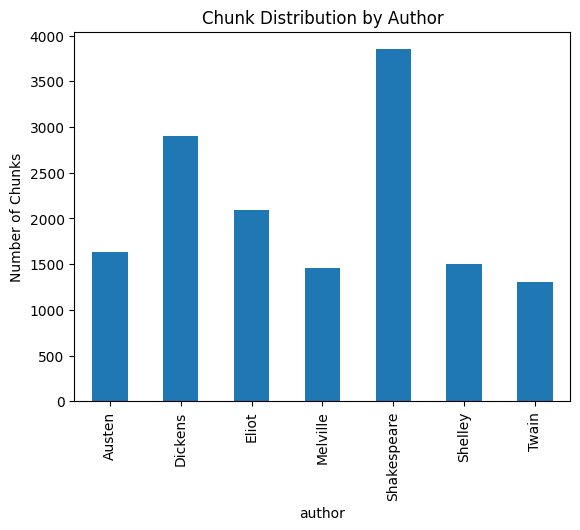

In [28]:
import matplotlib.pyplot as plt

author_counts = df_exploded.groupBy("author").count().toPandas()
author_counts.plot(kind='bar', x='author', y='count', legend=False)
plt.ylabel("Number of Chunks")
plt.title("Chunk Distribution by Author")
plt.show()


In [29]:
#Converting Words to Integers for the LSTM model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Collect all chunks into Python list
chunks = [ " ".join(row.chunk) for row in df_exploded.collect() ]
authors = [row.author for row in df_exploded.collect()]

# Tokenize
tokenizerLSTM = Tokenizer()
tokenizerLSTM.fit_on_texts(chunks)
sequences = tokenizerLSTM.texts_to_sequences(chunks)

# Pad sequences to fixed length
max_len = 200
X = pad_sequences(sequences, maxlen=max_len)


C:\Users\brice\anaconda3\envs\spark_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\brice\anaconda3\envs\spark_env\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [30]:
#Encoding labels (Authors)

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode author names into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(authors)

# One-hot encode labels (for softmax output)
y = to_categorical(y)

num_classes = y.shape[1]


In [31]:
#TRAINING


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69, stratify=y
)


In [32]:
#Building the model:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

vocab_size = len(tokenizerLSTM.word_index) + 1  # total unique words
embedding_dim = 128
max_len = 200  # same as your padded length

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          9804288   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 9,944,583
Trainable params: 9,944,583
Non-

In [33]:
#Fitting/training the model (TAKES A WHILE)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5, #10,           # try 10–15 for better results
    batch_size=64,
    verbose=1
)


Epoch 1/5
148/148 [==============================] - 57s 368ms/step - loss: 1.5711 - accuracy: 0.3670 - val_loss: 1.3606 - val_accuracy: 0.4446
Epoch 2/5
148/148 [==============================] - 54s 366ms/step - loss: 1.1223 - accuracy: 0.5629 - val_loss: 1.0962 - val_accuracy: 0.5286
Epoch 3/5
148/148 [==============================] - 58s 395ms/step - loss: 0.9119 - accuracy: 0.6297 - val_loss: 1.2385 - val_accuracy: 0.5643
Epoch 4/5
148/148 [==============================] - 57s 383ms/step - loss: 0.5607 - accuracy: 0.7846 - val_loss: 0.5331 - val_accuracy: 0.8316
Epoch 5/5
148/148 [==============================] - 56s 380ms/step - loss: 0.3489 - accuracy: 0.8774 - val_loss: 0.6817 - val_accuracy: 0.7531


In [34]:
#Simple Evaluation
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.2f}")


Test Accuracy: 0.76


In [35]:
#prediction



import numpy as np

def predict_author(text):
    # Clean text
    text = clean_text(text)
    # Tokenize and pad
    seq = tokenizerLSTM.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    # Predict
    pred = model.predict(padded, verbose=0)
    idx = np.argmax(pred)
    author = label_encoder.inverse_transform([idx])[0]
    confidence = np.max(pred)
    return author, confidence

# Example
sample = "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife."
print(predict_author(sample))
#Answer: "Austen"



('Shakespeare', 0.97687805)


In [36]:
sample = " ".join([
    "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.",
    "However little known the feelings or views of such a man may be on his first entering a neighbourhood..."
])
print(predict_author(sample))
#Answer: "Austen"

('Shakespeare', 0.32126513)


In [37]:
sample = "Beware; for I am fearless, and therefore powerful."
print(predict_author(sample))
#Answer: "Shelley"


('Shakespeare', 0.99651474)


In [38]:
sample= "In her looks and manner she was at once proud and contemptuous of me; yet I thought I detected in her a certain air of being almost weary of contempt for me, as if she were tired of the labor of having me despised by her and cared no more for it. Still, she treated me as before: except that she no longer looked at me with the scornful wonder of how I could have been so weak as to have been betrayed into admiration of her beauty. The change was made in her demeanor, and it deeply penetrated my heart."
print(predict_author(sample))
#Answer: "Dickens"


('Shelley', 0.9175197)


In [39]:
sample = "My crown is called content, a crown that seldom kings enjoy. There is nothing either good or bad but thinking makes it so. The empty vessel makes the loudest sound. Better three hours too soon than a minute too late. When a father gives to his son, both laugh; when a son gives to his father, both cry."
print(predict_author(sample))
#Answer: "Shakespeare"


('Shakespeare', 0.99543685)


In [40]:
# Save model as .h5
#cwd
model.save(r"Models/stylometric_modelv2.h5")

##Chatbot Section:

The Following section is concerned with the development of a chatbot functionality, that is capable of personalised information, and fun interaction with the user. This model is responsible for acting as an interface with the previous stylometric model, and engaging with the user

A couple approaches were considered for this:
-1) A rule based retireval chatbot
-2) A Retrival-Augmented Chatbot
-3) A Generative chatbot (Neural network Agent)

I immediately decided that the simple rule based retrieval bot was out of the question, since it would be simple to the point of boredom and
while the Gen AI agent is enticing, it maybe a bit too system intensive. 
THus I decided to train a model on the chunks previously developed for this project, in order to have a stylistically aware chat agent that is still relatively lightweight






In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

chunks = [row.chunk for row in df_exploded_raw.collect()]
authors = [row.author for row in df_exploded_raw.collect()]


# Each chunk as a string
#chunks = [ " ".join(row.chunk) for row in df_exploded.collect() ]
#authors = [row.author for row in df_exploded.collect()]

# Build TF-IDF (Retrieval) index
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(chunks)

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

#Retrieval function definition
def retrieve_chunks(query, top_k=3):
    query_vec = vectorizer.transform([query])
    sims = cosine_similarity(query_vec, X_tfidf).flatten()
    top_idx = sims.argsort()[-top_k:][::-1]
    return [(chunks[i], authors[i], sims[i]) for i in top_idx]


In [43]:
#response Logic

def rag_chatbot(query):
    results = retrieve_chunks(query, top_k=2)
    print("Relevant passages:\n")
    for text, author, score in results:
        print(f"Author: {author} | Score: {score:.2f}")
        print(text[:300], "...\n")
    # For a prototype, return the most relevant chunk
    return f"{results[0][1]} might say something like:\n{results[0][0][:500]}"


In [44]:

#pip install --upgrade gradio


In [45]:



#Gradio is a web-browser based UI framework that is used frequntly for tech demos on hugginface and github
#it works well for our purposes as a means of testing the chatbot...
import gradio as gr

def chatbot_interface(user_input):
    return rag_chatbot(user_input)


demo = gr.Interface(
    fn=chatbot_interface,
    inputs=gr.Textbox(lines=3, placeholder="Ask about a book...", label="Your Question"),
    outputs=gr.Textbox(lines=15, label="Answer"),
    title="Book-Based RAG Chatbot",
    description="Ask questions and I’ll retrieve passages from the books dataset."
)





demo.launch()


C:\Users\brice\anaconda3\envs\spark_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [46]:
import transformers
print(transformers.__version__)


4.56.2


In [47]:
import pyarrow as pa
import pyarrow.parquet as pq
print(pa.__version__)

21.0.0


In [48]:
#Language model mark 2

from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, TextDataset, DataCollatorForLanguageModeling

# 1. Load tokenizer & model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# 2. Prepare dataset (just a .txt file with your novels concatenated)
def load_dataset(file_path, tokenizer, block_size=512):
    return TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size
    )

train_dataset = load_dataset("literature_corpus.txt", tokenizer)

# 3. Data collator (for padding)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
)

# 4. Training setup
training_args = TrainingArguments(
    output_dir="./literary_gpt2",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
)

# 5. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# 6. Train!
trainer.train()

# 7. Save model
trainer.save_model("./literary_gpt2")
tokenizer.save_pretrained("./literary_gpt2")


In [49]:
from transformers import pipeline

generator = pipeline("text-generation", model="./literary_gpt2", tokenizer="./literary_gpt2")

prompt = "User: What is love?\nShakespeare:"
print(generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"])


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


User: What is love?
Shakespeare: Love is not love.

MISTRESS PERICLES.
But, madam, we must love.

KING.
Love is not love.

MISTRESS PERICLES.
But, madam, we must love.

KING.
If you love, it is not love.

MISTRESS PERICLES.
I am very much mistaken.

KING.
I love you, madam.

MISTRESS PERICLES.
And yet I love you: but I do not love you to be sure
that there is anything more in love than love.

KING.
I love you, madam.

MISTRESS PERICLES.
I love you, madam, but I do not love you to say you did love
you, madam.

KING.
I know this, madam, I know it.

MISTRESS PERICLES.
I know it, madam, I know it.

KING.
I know it, madam.

MISTRESS PERICLES.
I know it, madam.

KING.
I


In [54]:


from transformers import pipeline

prompt = """You are a knowledgeable literature assistant. 
Answer questions in a clear, insightful way.

User: Who was Dante Alighieri?
Assistant: Dante Alighieri was a 13th–14th century Italian poet, best known for "The Divine Comedy," 
a landmark of medieval literature.

User: What is love?
Assistant:"""


print(generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"])


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


You are a knowledgeable literature assistant. 
Answer questions in a clear, insightful way.

User: Who was Dante Alighieri?
Assistant: Dante Alighieri was a 13th–14th century Italian poet, best known for "The Divine Comedy," 
a landmark of medieval literature.

User: What is love?
Assistant: Love is a very interesting idea, but I am afraid it is not
exactly the same as what it is to be a lover.

Guest: What is the meaning of the phrase,

Guest: Love is a pretty interesting idea. It comes from a Latin word meaning,
                                                                                                                                                                                                    


In [55]:


from transformers import pipeline

prompt = """You are a knowledgeable literature assistant. 
Answer questions in a clear, insightful way.

User: what style is the following verse "Tom appeared on the sidewalk with a bucket of whitewash and a long-handled brush. He surveyed the fence, and all gladness left him and a deep melancholy settled down upon his spirit. Thirty yards of board fence nine feet high. Life to him seemed hollow, and existence but a burden."

"""
print(generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"])


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


You are a knowledgeable literature assistant. 
Answer questions in a clear, insightful way.

User: what style is the following verse "Tom appeared on the sidewalk with a bucket of whitewash and a long-handled brush. He surveyed the fence, and all gladness left him and a deep melancholy settled down upon his spirit. Thirty yards of board fence nine feet high. Life to him seemed hollow, and existence but a burden."

 The first sentence of the verse

"Tom appeared on the sidewalk with a bucket of whitewash and a long-handled brush. He surveyed the fence, and all gladness left him and a deep melancholy settled down upon his spirit. Thirty yards of board fence nine feet high. Life to him seemed hollow, and existence but a burden."

The second sentence of the verse

"Tom appeared on the sidewalk with a bucket of whitewash and a long-handled brush. He surveyed the fence, and all gladness left him and a deep melancholy settled down upon his spirit. Thirty yards of board fence nine feet high."


In [50]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should be False

2.3.1
False


In [57]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import gradio as gr

# 1. Load fine-tuned GPT-2
model_path = "./literary_gpt2"
tokenizerGPT = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)
model.eval()

# 2. Backend functions
def rag_chat(history, message):
    # Call your real RAG pipeline here instead of reversing text
    answer = rag_chatbot(message)
    history = history + [(message, answer)]
    return history, ""

# 2a. Hidden system prompt (prepended to every user message)
hidden_prompt = """
You are a knowledgeable literature assistant.
Answer questions clearly, concisely, and factually about literature.

Q: Who was Dante Alighieri?
A: Dante Alighieri was a 13th–14th century Italian poet, best known for The Divine Comedy.

Q: What is love in Shakespeare's works?
A: Love in Shakespeare’s works is often complex, idealized, and sometimes tragic.

Q: """


def gpt2_chat(history, message, max_new_tokens=150, temperature=0.7, top_p=0.9):
    # Prepend hidden prompt concatenated with the user input
    full_input = hidden_prompt + message + "\nA:"

    # Encode input
    inputs = tokenizerGPT.encode(full_input, return_tensors="pt")

    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            pad_token_id=tokenizerGPT.eos_token_id
        )

    # Decode only the new output
    generated_text = tokenizerGPT.decode(outputs[0][inputs.shape[-1]:], skip_special_tokens=True)

    # Append to chat history
    history = history + [(message, generated_text.strip())]
    return history, ""


# 3. Gradio UI
with gr.Blocks(css="""
    #chatbot .message {font-size: 18px; line-height: 1.6;}
""") as demo:
    gr.Markdown("## Multi-Model Chat")

    with gr.Tabs() as tabs:
        #------------------RAG TAB ------------------
        with gr.Tab("RAG Model"):
            with gr.Row():
                msg_rag = gr.Textbox(show_label=False, placeholder="Type a message...")
                btn_rag = gr.Button("Send")
            chatbot_rag = gr.Chatbot(label="RAG Chat", elem_id="chatbot", height=400)
            state_rag = gr.State([])
            btn_rag.click(rag_chat, [state_rag, msg_rag], [chatbot_rag, msg_rag])

        #------------------GPT-2 TAB ------------------
        with gr.Tab("GPT-2 Model"):
            with gr.Row():
                msg_gpt2 = gr.Textbox(show_label=False, placeholder="Type a message...")
                btn_gpt2 = gr.Button("Send")
            chatbot_gpt2 = gr.Chatbot(label="GPT-2 Chat", elem_id="chatbot", height=400)
            state_gpt2 = gr.State([])
            btn_gpt2.click(gpt2_chat, [state_gpt2, msg_gpt2], [chatbot_gpt2, msg_gpt2])

demo.launch()


C:\Users\brice\AppData\Local\Temp\ipykernel_15528\4009227629.py:69: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot_rag = gr.Chatbot(label="RAG Chat", elem_id="chatbot", height=400)
C:\Users\brice\AppData\Local\Temp\ipykernel_15528\4009227629.py:78: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot_gpt2 = gr.Chatbot(label="GPT-2 Chat", elem_id="chatbot", height=400)


* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.
